# ECON408: Assignment 5

Jesse Perla, UBC

## Student Name/Number: Alexander Quach (62679758)

### Instructions

-   Edit the above cell to include your name and student number.
-   Submit just this `ipynb` to Canvas. Do not rename, it associates
    your student number with the submission automatically.

In [13]:
using Distributions, Plots, LaTeXStrings, LinearAlgebra, Statistics, Random, QuantEcon, NLsolve

## Question 1

Consider the original formulation of the asset pricing equations with
the stochastic discount factor $m_{t+1}$ in the [Lucas tree
model](https://jlperla.github.io/ECON408/lectures/asset_pricing_lucas_trees.html#/consumption-in-equilibrium)
with the [Price-to-Dividend
Ratio](https://jlperla.github.io/ECON408/lectures/asset_pricing_lucas_trees.html#/price-to-dividend-ratio-with-markov-chain)

$$
v(X_t) = \beta {\mathbb E}_t \left[ m_{t+1} \frac{d_{t+1}}{d_t} (1 + v(X_{t+1})) \right]
$$

where

$$
m_{t+1} = \beta \frac{u'(c_{t+1})}{u'(c_t)}
$$

Furthermore, we will consider there may be two processes for $m_{t+1}$
and the dividends:

$$
\frac{c_{t+1}}{c_t} = G_c(X_{t+1})
$$

and

$$
\frac{d_{t+1}}{d_t} = G_d(X_{t+1})
$$

With this, the price-dividend ratio equation becomes:

$$
v(X_t) = \beta {\mathbb E}_t \left[ G_c(X_{t+1})^{-\gamma} G_d(X_{t+1}) (1 + v(X_{t+1})) \right]
$$

and if $X_t \in S$ is a Markov chain with transition probabilities
$P(X_t, X_{t+1})$ then the price-dividend ratio equation becomes:

$$
v(x) = \beta \sum_{x'\in S} G_c(x')^{-\gamma} G_d(x') (1 + v(x'))P(x,x')
$$

The price of the asset itself follows,

$$
p(x) = \beta \sum_{x'\in S} G_c(x')^{-\gamma} (G_d(x') x + p(x'))P(x,x')
$$

### Part (a)

In the original lucas tree model, we had that $G_c(x) = G_d(x) = G(x)$.
i.e., perfect correlation between the consumption and dividend growth
processes.

This meant we could write the price-dividend ratio equation as:

$$
v(x) = \beta \sum_{x'\in S} G(x')^{1 -\gamma} (1 + v(x'))P(x,x')
$$

And if we stack up the $v(x)$ as a vector for each $x \in S$ then we can
write this as a linear system, define,

$$
J_{ij} \equiv G(x_j)^{1 - \gamma} P_{ij}
$$

Then the recursive equation (with $\mathbb{1}$ a stack of ones) is 
$$
v = \beta J (\mathbb{1} + v)
$$

with solution

$$
v = \left( I - \beta J \right)^{-1} \beta J \mathbb{1}
$$

Putting this into code with a discretized Markov chain from an AR(1)
process with a slight tweak from our original code

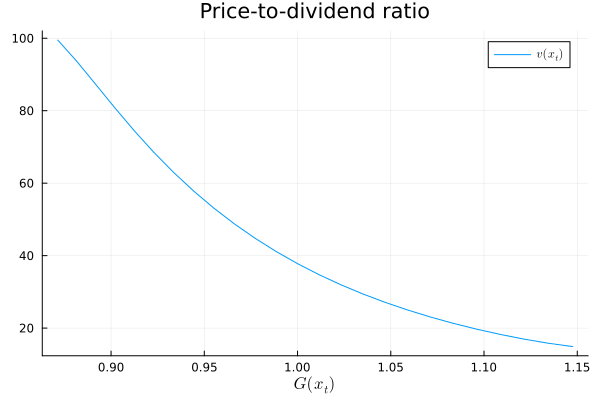

In [14]:
# Do not modify this code directly
function asset_pricing_model(; beta = 0.96, gamma = 2.0, G = exp,
                               rho = 0.9, sigma = 0.02, N = 25)
    mc = tauchen(N, rho, sigma)
    G_x = G.(mc.state_values)
    return (; beta, gamma, mc, G, G_x)
end

# price/dividend ratio of the Lucas tree
function tree_price(ap)
    (; beta, mc, gamma, G) = ap
    P = mc.p
    y = mc.state_values'
    J = P .* G.(y) .^ (1 - gamma)
    @assert maximum(abs, eigvals(J)) < 1 / beta # check stability
    v = (I - beta * J) \ sum(beta * J, dims = 2)
    return (;v)
end

ap = asset_pricing_model(;rho = 0.9) # change default arguments here.
sol = tree_price(ap)
plot(ap.G_x, sol.v, xlabel = L"G(x_t)", label = L"v(x_t)", title="Price-to-dividend ratio")

Change this code to plot the price-dividend ratio equation for a smaller
autocorrelation of $\rho = 0.1$.

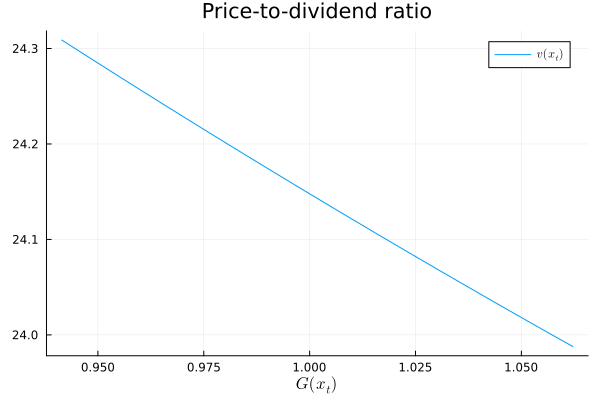

In [15]:
# Modify your code here
ap = asset_pricing_model(;rho = 0.1) # change default arguments here.
sol = tree_price(ap)
plot(ap.G_x, sol.v, xlabel = L"G(x_t)", label = L"v(x_t)", title="Price-to-dividend ratio")

Interpret differences in the equation, including the scale and the slope

A higher autocorrelation means that the markov chain has a strong memeory of the past. This implies that shocks to consumption and dividends tend to persist for longer periods of time. This means that there will be higher volatility in the price-dividend ratio, which we can see on the x axis. The slope will also be steeper. The change in ρ from 0.9 to 0.1 modifies the dynamics of the model. A higher rho leads to more persistent shocks, potentially causing larger fluctuations and a steeper relationship between the price-dividend ratio and the growth factor. Conversely, a lower ρ results in less persistent shocks, potentially generating smoother variations and a flatter relationship. This leads to the linearity in the second model

### Part (b)

Now, suppose we want to modify the original model so that the growth
rate of dividends is **inversely correlated** with the growth rate of
consumption. Specifically, let the relationship between consumption and
dividends be as follows:

$$
c_{t+1} = G(X_{t+1}) c_t \quad \text{and} \quad d_{t+1} = {G(-X_{t+1})}
$$

Because $G(X_{t+1}) = \exp(X_{t+1})$, this means we have

$$
m_{t+1} = \beta \exp(X_{t+1})^{-\gamma}
$$

and

$$
\frac{d_{t+1}}{d_t} = \frac{1}{\exp(X_{t+1})}
$$

What is the new price-dividend ratio equation? You can write this out in
LaTeX or keep it simple and describe the changes relative to the
previous equation.

$$
v(X_t) = \beta {\mathbb E}_t \left[ \beta \exp(X_{t+1})^{-\gamma} \frac{1}{\exp(X_{t+1})} (1 + v(X_{t+1})) \right]
$$

$$
v(X_t) = \beta^2 \sum_{X_{t+1}} P(X_t, X_{t+1}) [ \exp(X_{t+1})^{(-\gamma - 1)} \cdot (1 + v(X_{t+1})) ]
$$

The change reflects the opposing effects of consumption and dividend growth on the future payoff. When consumption goes up (positive X_(t+1)), the discount factor reduces the payoff due to the negative exponent. However, the dividend growth term (1 + v(X_(t+1))) might counteract this effect.
Overall, the new equation captures the relationship between consumption and dividend growth dynamics under inverse correlation within the Lucas tree model.

### Part (c)

Take the following code from above for the standard Lucas tree (with
perfectly correlated growth rate of dividends and consumption of that
asset) and modify it to solve for the price-dividend ratio equation for
the new model using the formula above. Note some small changes in the
parameters

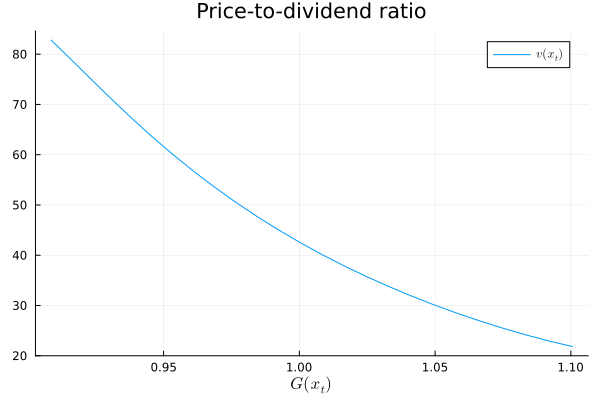

In [16]:
# modify here
function new_asset_pricing_model(; beta = 0.96, gamma = 2.0, G = exp,
                               rho = 0.7, sigma = 0.02, N = 25)
    mc = tauchen(N, rho, sigma)
    G_x = G.(mc.state_values)
    return (; beta, gamma, mc, G, G_x)
end

function new_tree_price(ap)
    (; beta, mc, gamma, G) = ap
    P = mc.p
    y = mc.state_values'
    J = P .* G.(y) .^ (-1 - gamma)
    @assert maximum(abs, eigvals(J)) < 1 / beta # check stability
    v = (I - beta * J) \ sum(beta * J, dims = 2)
    return (;v)
end

ap = new_asset_pricing_model(;rho = 0.78, gamma = 1.2)
sol = new_tree_price(ap)
plot(ap.G_x, sol.v, xlabel = L"G(x_t)", label = L"v(x_t)", title="Price-to-dividend ratio")

Interpret this result compared to the previous example with perfectly
correlated growth rates. In particular, discuss the differences in
magnitudes.

 The plot provides visual evidence that introducing inverse correlation between consumption and dividend growth rates in the Lucas tree model can lead to a decrease in the magnitude of the price-dividend ratio compared to the case of perfect correlation. The shape of the curves are similar, however the maginitudes of the differences are simply reduced in this case compared to the previous one.